In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import csv
import nest_asyncio
nltk.download('stopwords')
nltk.download('punkt')
seed = 10
np.random.seed(seed)
sns.set(style = 'whitegrid')
nest_asyncio.apply()
# pd.options.mode.chained_assignment = True
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from  sklearn.metrics import confusion_matrix
import emoji
import string


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def remove_emoji():
    """menghilangkan emoji"""
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

begone_emoji = remove_emoji()

def remove_three_same_char(value):
    """menghilangkan repitisi 3 karakter berurutan seperti gooooool"""
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", value)
def cleaning_text(value):
  result = value.lower().strip()
  result = remove_three_same_char(result)
  result = ' '.join(result.split())
  result = re.sub(r'(@|https?)\S+|#[A-Za-z0-9_]+', '', result).replace("&amp;", "dan")
  result = re.sub(r'RT[\s]+','',result)
  result = begone_emoji.sub(repl='', string=result)
  result = re.sub(r'[0-9]+','',result)
  result = result.replace('\n', ' ')
  result = result.translate(str.maketrans('','',string.punctuation))
  return result

def tokenizing_text(value):
  result= word_tokenize(value)
  return result

def filtering_stopwords(value):
  list_stopwords = set(stopwords.words('indonesian'))
  filtered = []
  for text in value:
    if text not in list_stopwords:
      filtered.append(text)
  return filtered

def stemming_text(value):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return [stemmer.stem(word) for word in value]

def sentence_make(tokenized):
  return ' '.join(word for word in tokenized)


def remove_slang(value):
    kamus = eval(open("combined_slang_words.txt").read())
    pattern = re.compile(r"\b(%s)\b" % "|".join(kamus))
    converted = pattern.sub(lambda word: kamus.get(word.group()), value)
    # clear = re.sub(r'[^\w\s]', ' ', converted)
    return converted

In [3]:
df_etle = pd.read_excel('data oktober-des 2022 etilang tanpa lang dan etle.xlsx')
df_etle.head()

,text_id
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ..."
1,Sosialisasi etle dan app smart city\n\n#polsek...
2,"Berita populer kumparanOTO, Selasa (13/12) det..."
3,"Mimin kasih info ya gaes, kita mau uji coba ET..."
4,personil lalu lintas polres badung melaksanaka...


In [4]:
df_etle['tweet_cleaned_id'] = df_etle['text_id'].apply(cleaning_text)
df_etle.head()

,text_id,tweet_cleaned_id
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",kembangkan etle polda dapat penghargaan di ra...
1,Sosialisasi etle dan app smart city\n\n#polsek...,sosialisasi etle dan app smart city
2,"Berita populer kumparanOTO, Selasa (13/12) det...",berita populer kumparanoto selasa detail vesp...
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",mimin kasih info ya gaes kita mau uji coba etl...
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung melaksanaka...


In [5]:
df_etle['tweet_preprocessed'] = df_etle['tweet_cleaned_id'].apply(remove_slang)
df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(tokenizing_text)
df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(filtering_stopwords)
df_etle['tweet_preprocessed'] = df_etle['tweet_preprocessed'].apply(stemming_text)

df_etle.drop_duplicates(subset = 'tweet_cleaned_id', inplace = True  )

TypeError: drop_duplicates() got an unexpected keyword argument 'inpace'

In [6]:
df_etle

,text_id,tweet_cleaned_id,tweet_preprocessed
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",kembangkan etle polda dapat penghargaan di ra...,"[kembang, etle, polda, harga, rakernis, fungsi..."
1,Sosialisasi etle dan app smart city\n\n#polsek...,sosialisasi etle dan app smart city,"[sosialisasi, etle, app, smart, city]"
2,"Berita populer kumparanOTO, Selasa (13/12) det...",berita populer kumparanoto selasa detail vesp...,"[berita, populer, kumparanoto, selasa, detail,..."
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",mimin kasih info ya gaes kita mau uji coba etl...,"[mimin, kasih, informasi, iya, teman, uji, cob..."
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung melaksanaka...,"[personil, lintas, polres, badung, laksana, te..."
...,...,...,...
7616,Jumlah dakgar lantas selama 1x24 jam yang terc...,jumlah dakgar lantas selama x jam yang tercapt...,"[dakgar, lantas, x, jam, tercapture, kamera, e..."
7617,Pihak Kepolisian makin canggih perlengkapannya...,pihak kepolisian makin canggih perlengkapannya...,"[polisi, canggih, lengkap, tindak, pelanggara,..."
7618,IPW Minta Polri Tak Ragu Terapkan Tilang Manua...,ipw minta polri tak ragu terapkan tilang manua...,"[ipw, polri, ragu, terap, bukti, langgar, manu..."
7619,Sosialisasi E-TLE ( Elektronic Trafic Law Enfo...,sosialisasi etle elektronic trafic law enforv...,"[sosialisasi, etle, elektronic, trafic, law, e..."


In [7]:
df_etle.to_csv('colab_data_clean.csv', index=False, sep=';', header = True, index_label=None)


In [18]:
def lexicon_reader(path: str) -> dict:
    with open(path, 'r') as csv_data:
        bucket = dict()
        reader = list(csv.reader(csv_data, delimiter =","))
        for row in reader[1:]:
        # print(row[0])
            bucket[row[0]] = int(row[1])
    return bucket

def sentiment_lexicon_indonesia(value):
  score = 0
  for word in value:
    if word in lexicon_positive:
        score += lexicon_positive[word]
    if word in lexicon_negative:
        score += lexicon_negative[word]
  if score > 0:
    polarity = 'positif'
  elif score < 0:
    polarity = 'negatif'
  else:
    polarity = 'netral'
  return score, polarity

lexicon_positive = lexicon_reader('positive.csv')
lexicon_negative = lexicon_reader('negative.csv')



In [19]:
sentiment = df_etle['tweet_preprocessed'].apply(sentiment_lexicon_indonesia)
sentiment = list(zip(*sentiment))
df_etle['polarity_score'] = sentiment[0]
df_etle['polarity'] = sentiment[1]

df_etle.to_csv('colab_data_clean_polarity.csv', index = False, header = True, index_label = False)
df_etle['polarity'].info()
df_etle

<class 'pandas.core.series.Series'>
RangeIndex: 7621 entries, 0 to 7620
Series name: polarity
Non-Null Count  Dtype 
--------------  ----- 
7621 non-null   object
dtypes: object(1)
memory usage: 59.7+ KB


,text_id,tweet_cleaned_id,tweet_preprocessed,polarity_score,polarity
0,"Kembangkan ETLE, 7 Polda Dapat Penghargaan di ...",kembangkan etle polda dapat penghargaan di ra...,"[kembang, etle, polda, harga, rakernis, fungsi...",6,positif
1,Sosialisasi etle dan app smart city\n\n#polsek...,sosialisasi etle dan app smart city,"[sosialisasi, etle, app, smart, city]",0,netral
2,"Berita populer kumparanOTO, Selasa (13/12) det...",berita populer kumparanoto selasa detail vesp...,"[berita, populer, kumparanoto, selasa, detail,...",7,positif
3,"Mimin kasih info ya gaes, kita mau uji coba ET...",mimin kasih info ya gaes kita mau uji coba etl...,"[mimin, kasih, informasi, iya, teman, uji, cob...",7,positif
4,personil lalu lintas polres badung melaksanaka...,personil lalu lintas polres badung melaksanaka...,"[personil, lintas, polres, badung, laksana, te...",-5,negatif
...,...,...,...,...,...
7616,Jumlah dakgar lantas selama 1x24 jam yang terc...,jumlah dakgar lantas selama x jam yang tercapt...,"[dakgar, lantas, x, jam, tercapture, kamera, e...",0,netral
7617,Pihak Kepolisian makin canggih perlengkapannya...,pihak kepolisian makin canggih perlengkapannya...,"[polisi, canggih, lengkap, tindak, pelanggara,...",-8,negatif
7618,IPW Minta Polri Tak Ragu Terapkan Tilang Manua...,ipw minta polri tak ragu terapkan tilang manua...,"[ipw, polri, ragu, terap, bukti, langgar, manu...",-6,negatif
7619,Sosialisasi E-TLE ( Elektronic Trafic Law Enfo...,sosialisasi etle elektronic trafic law enforv...,"[sosialisasi, etle, elektronic, trafic, law, e...",-1,negatif


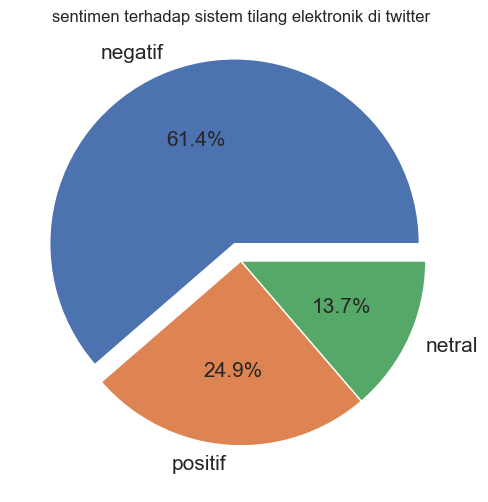

In [20]:
fig, ax = plt.subplots(figsize = (6,6))
sizes = [row for row in df_etle['polarity'].value_counts()]
label = list(df_etle['polarity'].value_counts().index)
explode = (0.1, 0,0)
ax.pie(x=sizes, labels=label, autopct = '%1.1f%%', explode=explode, textprops={'fontsize':15})
ax.set_title('sentimen terhadap sistem tilang elektronik di twitter')
plt.show()

In [26]:
X = df_etle['tweet_preprocessed'].apply(sentence_make)
max_feature = 5000

tokenizer = Tokenizer(num_words=max_feature, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X

array([[   0,    0,    0, ..., 1445,  429,  405],
       [   0,    0,    0, ...,  137,   62,   63],
       [   0,    0,    0, ...,    1,    2,   12],
       ...,
       [   0,    0,    0, ...,    1,   11,    2],
       [   0,    0,    0, ..., 3229, 3526, 3527],
       [   0,    0,    0, ..., 2072,  432, 1245]])

In [27]:
polarity_encode = {'negatif':0, 'netral':1, 'positif':2 }
y = df_etle['polarity'].map(polarity_encode).values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6096, 53) (6096,)
(1525, 53) (1525,)


In [36]:
from keras.backend import dropout
def create_model(embed_dim=16, hidden_unit=16, dropout_rate=0.2, optimizers=Adam, learning_rate=0.001):
  model = Sequential()
  model.add(Embedding(input_dim = max_feature, output_dim = embed_dim, input_lenght = X_train.shape[1]))
  model.add(LSTM(unit = hidden_unit, activation = 'tanh'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=3, activation = 'softmax' ))
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers(lr=learning_rate), metrics = ['accuracy'])
  print(model.summary())
  return model

In [63]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000,output_dim=16, input_length=X.shape[1]))
model_lstm.add(LSTM(units=16, activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=3, activation="softmax"))


model_lstm.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

scores = model_lstm.evaluate(X_test, y_test, verbose=False)
print(f"Accuracy: {scores[1]*100} %")

Epoch 1/10
48/48 [==============================] - 4s 22ms/step - loss: 0.9768 - accuracy: 0.6027 - val_loss: 0.8934 - val_accuracy: 0.6052
Epoch 2/10
48/48 [==============================] - 1s 14ms/step - loss: 0.8174 - accuracy: 0.6275 - val_loss: 0.7311 - val_accuracy: 0.6623
Epoch 3/10
48/48 [==============================] - 1s 14ms/step - loss: 0.6668 - accuracy: 0.6977 - val_loss: 0.6473 - val_accuracy: 0.7246
Epoch 4/10
48/48 [==============================] - 1s 14ms/step - loss: 0.5637 - accuracy: 0.7633 - val_loss: 0.5780 - val_accuracy: 0.7751
Epoch 5/10
48/48 [==============================] - 1s 14ms/step - loss: 0.4770 - accuracy: 0.8092 - val_loss: 0.5374 - val_accuracy: 0.7882
Epoch 6/10
48/48 [==============================] - 1s 13ms/step - loss: 0.4035 - accuracy: 0.8287 - val_loss: 0.4956 - val_accuracy: 0.8007
Epoch 7/10
48/48 [==============================] - 1s 13ms/step - loss: 0.3513 - accuracy: 0.8410 - val_loss: 0.4822 - val_accuracy: 0.8059
Epoch 8/10
48

In [72]:
model_json = model_lstm.to_json()
with open("model_lstm_86.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lstm.save_weights("model_lstm_86.h5")
print("Saved model to disk")

Saved model to disk


In [37]:
model_lstm = KerasClassifier(build_fn=create_model,
                        dropout_rate = 0.2,
                        embed_dim = 64,
                        hidden_unit = 32,
                        optimizers = Adam,
                        learning_rate = 0.001,
                        epochs=10,
                        batch_size=128,
                        validation_split=0.1)
model_prediction = model_lstm.fit(X_train, y_train)

C:\Users\MSI\AppData\Local\Temp\ipykernel_9096\1475363067.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_lstm = KerasClassifier(build_fn=create_model,


TypeError: ('Keyword argument not understood:', 'input_lenght')

In [71]:
x = model_lstm.history.history.keys()
x

dict_keys([])

TypeError: 'History' object is not subscriptable

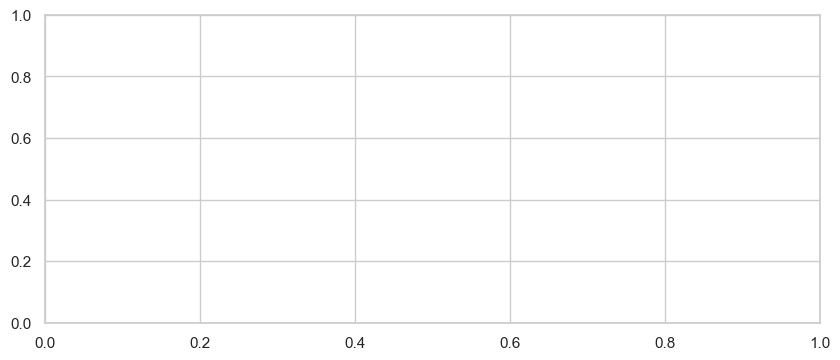

In [64]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(model_lstm.history['acc'], label = 'train_accuracy')
ax.plot(model_lstm.history['val_accuracy'], label = 'validation_accuracy')
ax.set_title('Model accuracy')
ax.set_xlabel('epochs')
ax.set_xlabel('accuracy')
ax.legend(loc = 'upper left')
plt.show()

In [45]:
y_pred = model_lstm.predict(X_test)
y_pred

48/48 [==============================] - 0s 3ms/step


array([[5.6524682e-01, 3.4025243e-01, 9.4500676e-02],
       [9.8743105e-01, 9.9795405e-03, 2.5894290e-03],
       [9.9955899e-01, 4.0555827e-04, 3.5361663e-05],
       ...,
       [2.2923430e-02, 2.5994858e-01, 7.1712798e-01],
       [8.1217670e-01, 1.4787522e-01, 3.9948020e-02],
       [7.4603304e-02, 4.0339792e-01, 5.2199882e-01]], dtype=float32)

In [42]:
y_pred = model_lstm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on test data: ', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'b', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 13)
ax.set_xticklabels(['negatif (0)', 'netral (1)', 'positif (2)'])
ax.set_ylabel('Actual', fontsize=13)
ax.set_yticklabels(['negatif (0)', 'netral (1)', 'positif (2)'])
plt.show()

48/48 [==============================] - 1s 3ms/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets